# 目標
- cross validation やる 

In [3]:
%load_ext autoreload

In [41]:
%autoreload 2

import os
import sys
import json

import pickle 


from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.model_selection import cross_val_score

import lightgbm as lgb

sys.path.append("../")
from src.model import MLModel
from src.featuring import add_feature

import warnings
warnings.filterwarnings('ignore')

In [5]:

class TimeSeriesSplitGroups(_BaseKFold):
    def __init__(self, n_splits=5):
        super().__init__(n_splits, shuffle=False, random_state=None)

    def split(self, X, y=None, groups=None):
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_list = np.unique(groups)
        n_groups = len(group_list)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_groups))
        indices = np.arange(n_samples)
        test_size = (n_groups // n_folds)
        test_starts = range(test_size + n_groups % n_folds,
                            n_groups, test_size)
        test_starts = list(test_starts)[::-1]
        for test_start in test_starts:
            
            yield (indices[groups.isin(group_list[:test_start])],
                   indices[groups.isin(group_list[test_start:test_start + test_size])])


# Config

In [6]:
class cfg:
    exp = "exp003"
    dataset_path = "../dataset/v5.0"
    feature_set = "small"
    n_splits = 5
    
    model_type = "lightgbm"
    task = "regression"
    model_params = {
        "n_estimators": 2000,
        "max_depth": 5,
        "learning_rate": 0.01,
        "feature_fraction": 0.1,
        "seed": 42,
    }
    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
# TODO: 特徴量もこの中に入れる
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)


In [7]:
with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set]
print(f"feature col length: {len(feature_set)}")

feature col length: 42


# Load Data

In [27]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era", "target"] + feature_set
)


print(train.shape)
display(train.head(2))


valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era", "target"] + feature_set
)
print(valid.shape)
display(valid.head(2))

(2746270, 44)


,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,feature_tridactyl_immoral_snorting,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,0.25,2,2,2,2,2,0,1,2,...,4,1,1,3,0,2,2,3,3,2
n003bba8a98662e4,0001,0.25,2,2,2,2,2,1,4,2,...,4,2,0,0,0,2,2,4,4,2


(3553377, 44)


,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,feature_tridactyl_immoral_snorting,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,0.75,0,2,1,2,2,1,1,2,...,1,2,3,0,2,2,1,3,2,0
n001e1318d5072ac,0575,0.00,1,1,3,2,1,3,3,4,...,2,4,3,2,2,3,1,1,0,1


# Preprocess

In [28]:
# target が 20 日、 era が週次なので重複してる。ので era を間引く
train["era_int"] = train["era"].astype(int)
valid["era_int"] = valid["era"].astype(int)

cond_train = train["era_int"] % 4 == 0
cond_valid = valid["era_int"] % 4 == 0

train = train.loc[cond_train]
valid = valid.loc[cond_valid]

# Featuring

In [29]:


# train = add_feature(train)
# valid = add_feature(valid)

# Training

In [30]:
features = [col for col in train.columns if "feature" in col]
target = "target"
print(len(features))

42


In [32]:
model = MLModel(
    model_type=cfg.model_type,
    task=cfg.task,
    model_params=cfg.model_params,
)

cv = TimeSeriesSplitGroups(n_splits=cfg.n_splits)

training_models = []


for i, (train_idx, valid_idx) in enumerate(cv.split(
    train[features],
    train[target],
    groups=train["era"]
)):
    print(x_train.shape, x_valid.shape)
    
    x_train, y_train = train.iloc[train_idx][features], train.iloc[train_idx][target]
    x_valid, y_valid = train.iloc[valid_idx][features], train.iloc[valid_idx][target]
    
    model.train(
        x_train,
        y_train,
        eval_set=(x_valid, y_valid),
        early_stopping_rounds=10
    )

    model.save_model(os.path.join(cfg.exp, f"model_{i}.pkl"))
    training_models.append(model)

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

(101852, 42) (112658, 42)
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 566204, number of used features: 42
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature

# Validation

In [33]:
preds = np.zeros(len(valid))

for training_model in training_models:
    preds += training_model.predict(valid[features]) / len(training_models)
valid["pred"] = preds

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (

In [34]:
# CORJ60, FNCV3, CORR2OV2, MMC, BMC, CORT20
# meta_model.parquet にはvalidationの最新eraの値が入ってる


meta_model_path = os.path.join(cfg.dataset_path, "meta_model.parquet")
meta_model = pd.read_parquet(meta_model_path)
print(meta_model.shape)
display(meta_model.head())

valid = pd.merge(valid.reset_index(), meta_model.reset_index(), how="left", on=["era", "id"]).set_index("id")
display(valid.head()) 


(75642, 3)


,era,data_type,numerai_meta_model
id,,,
n0001a161ef7f066,1133,validation,0.598030
n000683e569f9b8b,1133,validation,0.760381
n000df72d86f2b54,1133,validation,0.851571
n002303a67dd341c,1133,validation,0.748982
n00251ccb477cbb1,1133,validation,0.833659


,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute,era_int,pred,data_type,numerai_meta_model
id,,,,,,,,,,,,,,,,,,,,,
n0004e3727abc707,0576,0.25,0,1,2,0,0,0,4,2,...,3,0,0,2,4,1,576,0.497659,NaN,NaN
n0008ecf930b3229,0576,0.50,3,4,3,4,1,0,2,0,...,0,1,4,2,4,0,576,0.502144,NaN,NaN
n0020c1ded3995bd,0576,0.50,1,0,4,0,1,0,0,4,...,1,4,3,0,4,1,576,0.503476,NaN,NaN
n002fd4bd9a3b3c6,0576,0.25,1,4,2,2,1,2,2,2,...,2,1,4,4,4,3,576,0.500842,NaN,NaN
n00301428d7ba61f,0576,0.00,4,2,4,4,1,2,3,3,...,1,3,3,2,3,4,576,0.500993,NaN,NaN


<AxesSubplot: title={'center': 'Validation CORR'}, xlabel='era'>

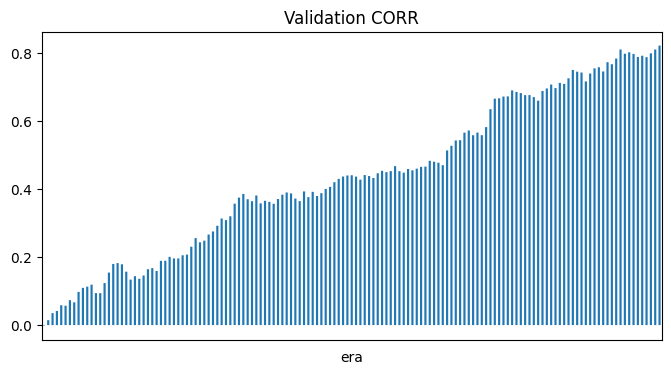

In [35]:

per_era_corr = valid[["era", "target", "pred"]].dropna().groupby("era").apply(
    lambda x: numerai_corr(x[["pred"]].dropna(), x["target"].dropna())
)
# Plot the per-era correlation
per_era_corr.cumsum().plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)



In [36]:
per_era_sharpe_ratio = per_era_corr["pred"].mean() / per_era_corr["pred"].std()
print(per_era_sharpe_ratio)

0.40914970534278283


<AxesSubplot: title={'center': 'Validation MMC'}, xlabel='era'>

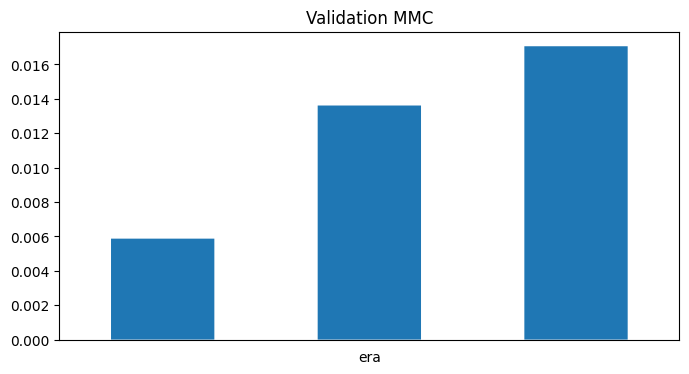

In [37]:

per_era_mmc = valid[["era", "target", "pred", "numerai_meta_model"]].dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["pred"]], x["numerai_meta_model"], x["target"])
)
# Plot the per-era correlation
per_era_mmc.cumsum().plot(
  title="Validation MMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)



In [38]:
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std()
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()
 
mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std()
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

pd.DataFrame({
    "exp": [cfg.exp],
    "corr_mean": [corr_mean.values[0]],
    "corr_std": [corr_std.values[0]],
    "corr_shape": [corr_sharpe.values[0]],
    "corr_max_drawdown": [corr_max_drawdown.values[0]],
    
    "mmc_mean": [mmc_mean.values[0]],
    "mmc_std": [mmc_std.values[0]],
    "mmc_shape": [mmc_sharpe.values[0]],
    "mmc_max_drawdown": [mmc_max_drawdown.values[0]],
})

,exp,corr_mean,corr_std,corr_shape,corr_max_drawdown,mmc_mean,mmc_std,mmc_shape,mmc_max_drawdown
0,exp003,0.005737,0.014023,0.40915,0.048536,0.005685,0.002153,2.640307,0.0


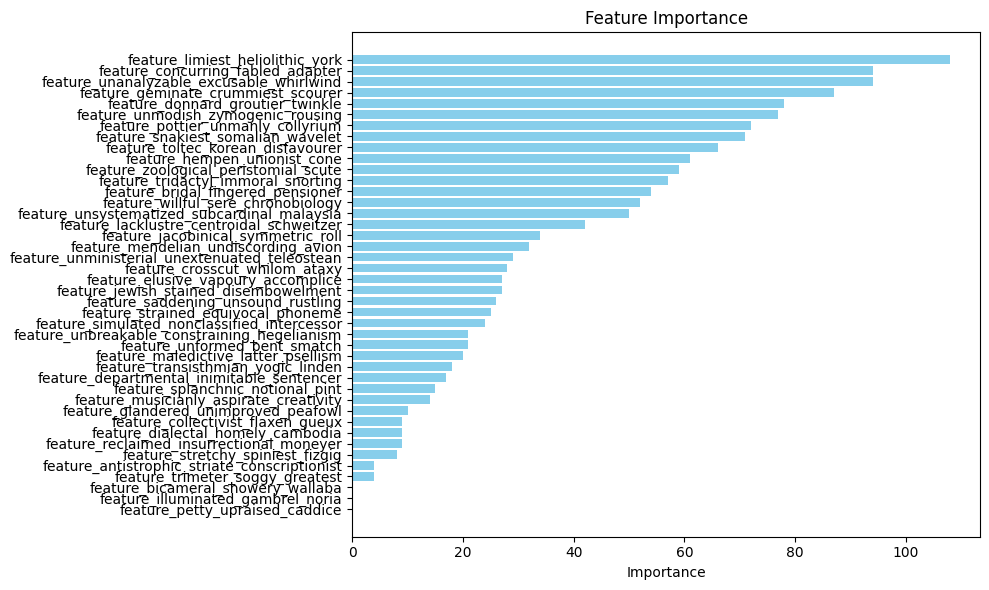

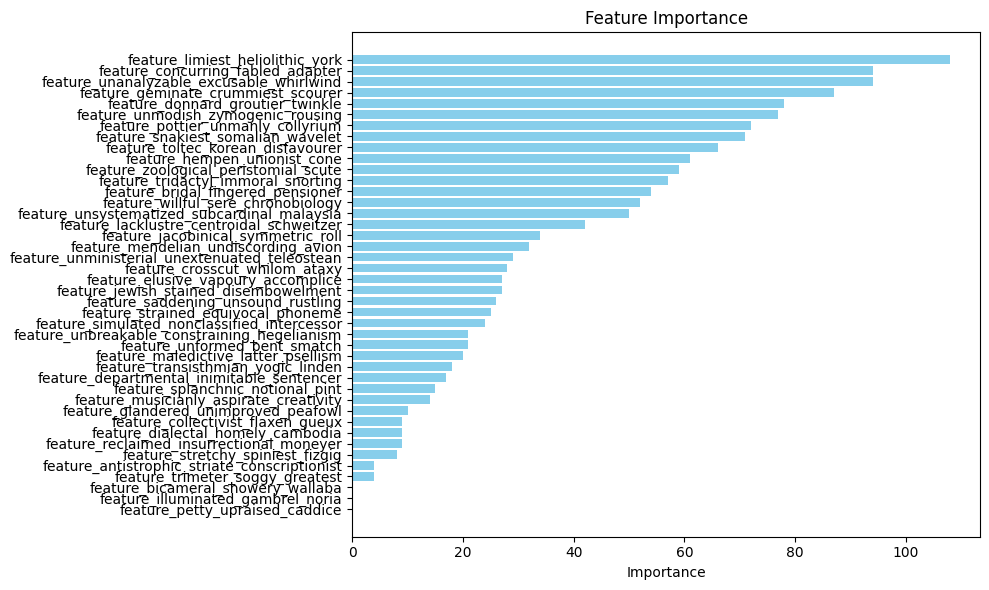

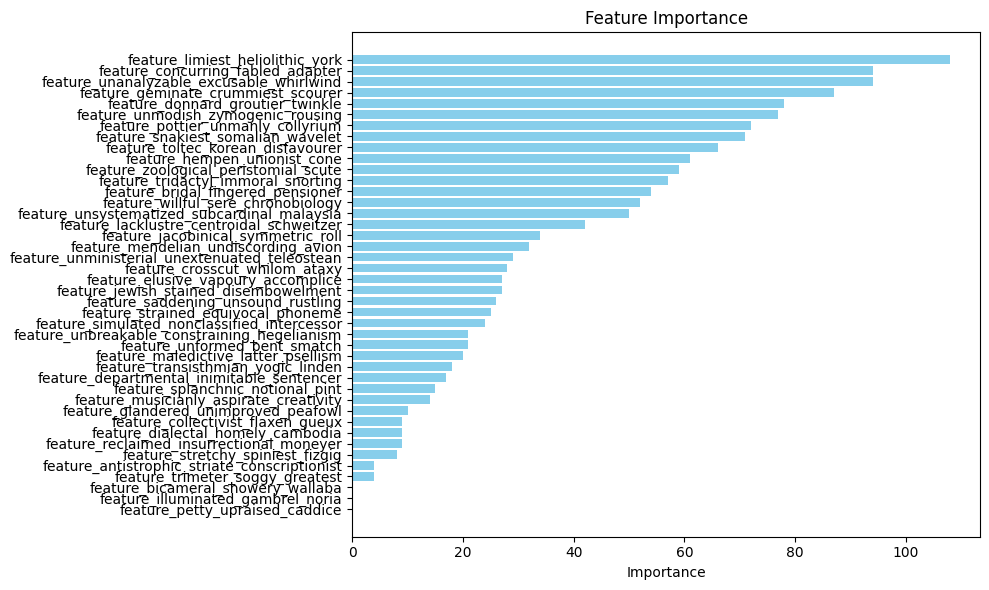

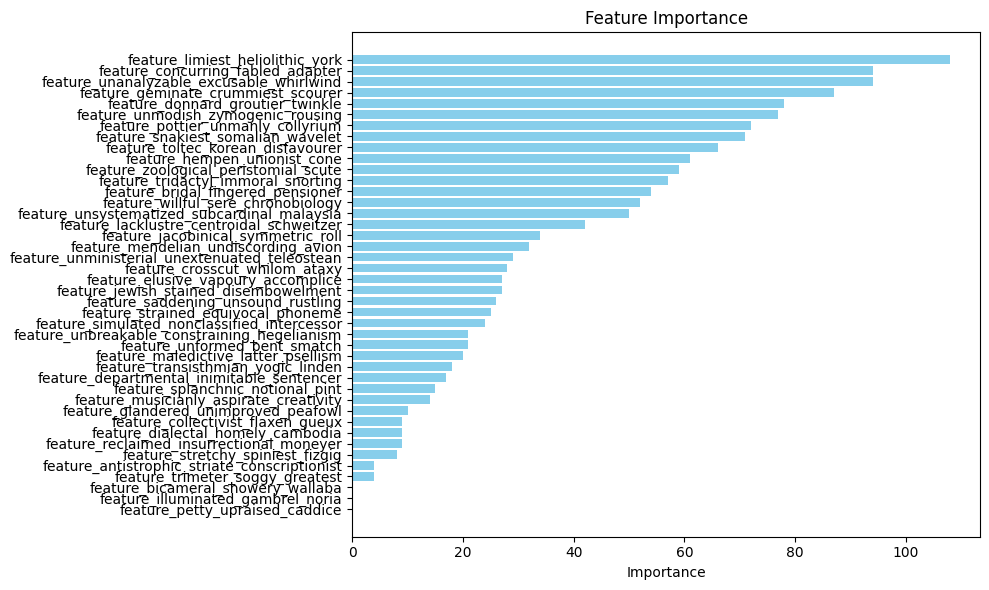

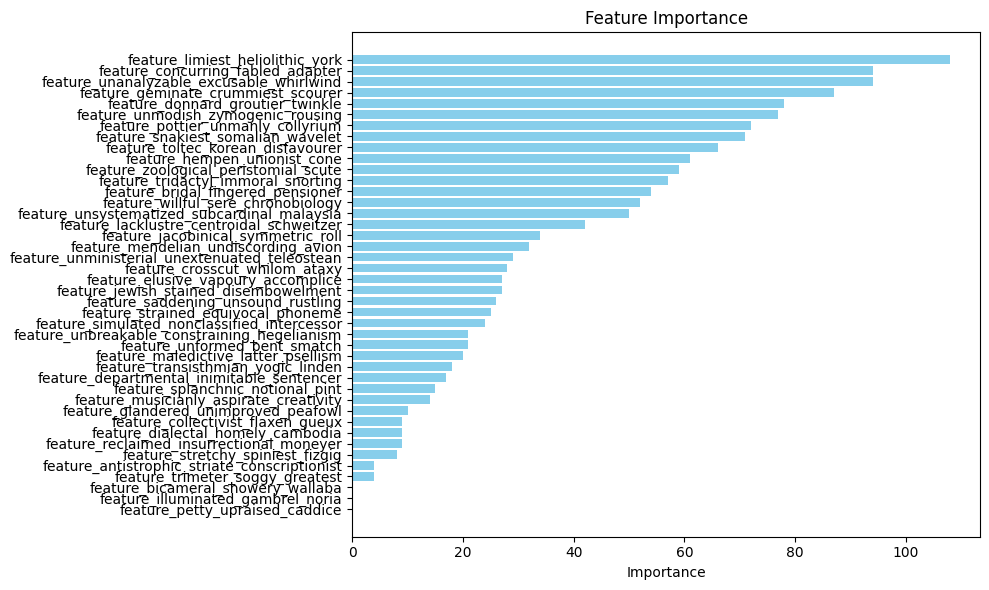

In [39]:
for model in training_models:
    model.visualize_feature_importance(feature_names=features, max_features=100)